In [1]:
from __future__ import division
import os
import sys
import json
import warnings
import struct
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import networkx as nx
from sklearn import preprocessing, manifold, decomposition, neighbors
from sklearn.model_selection import cross_val_score

#from tensorflow.examples.tutorials.mnist import input_data

import requests

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from IPython import display

#sys.path.append('/Users/zichen/Documents/bitbucket/maayanlab_utils/')
#from plots import COLORS10

np.random.seed(2017)
print(os.getcwd())

C:\Users\Charlotte\TestLayout


In [2]:
def read(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError, "dataset must be 'testing' or 'training'"

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], np.asarray(img[idx]).reshape(-1))

    # Create an iterator which returns each image in turn
    for i in xrange(len(lbl)):
        yield get_img(i)


In [3]:
#returns a list of tuples
training_data=list(read(dataset='training',path=''))
mnist_data=[x[1] for x in training_data]
mnist_labels=[x[0] for x in training_data]
#mndata=MNIST('Users/Charlotte/python-mnist/data')
#images, labels = mndata.load_training()


Retrieve the MNIST data and sample a subset to experiment on.

In [4]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [5]:
N=2000
X,labels =next_batch(N,mnist_data,mnist_labels)

In [6]:
print X.shape, labels.shape

(2000L, 784L) (2000L,)


In [7]:
#N = 2000 # number of samples
#X, labels = mnist.train.next_batch(N)
#print X.shape, labels.shape

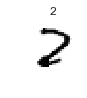

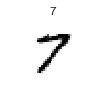

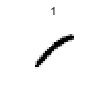

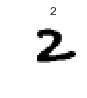

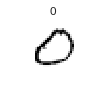

In [8]:
for i in range(5):
    plt.figure(figsize=(1,1))
    plt.imshow(X[i].reshape(28, 28))
    plt.axis('off')
    plt.title(labels[i])

#### Perform PCA on the data

(2000L, 784L)
Explained variance ratio by PCs: [ 0.09035763  0.07265781  0.06022543  0.05761543  0.04848677  0.04411186
  0.03300407  0.02932096  0.02868303  0.02334444  0.0215744   0.02040317
  0.01771562  0.01659593  0.01641059  0.01449048  0.0140933   0.01365048
  0.0130371   0.0118662 ]


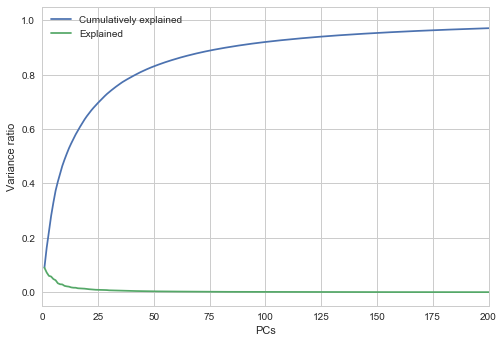

In [9]:
pca = decomposition.PCA()
X_pca = pca.fit_transform(X)
print X_pca.shape
print 'Explained variance ratio by PCs:', pca.explained_variance_ratio_[:20]
cum_var_explained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(len(cum_var_explained))+1, cum_var_explained, label='Cumulatively explained')
plt.plot(np.arange(len(cum_var_explained))+1, pca.explained_variance_ratio_, label='Explained')
plt.legend(loc='best')
plt.xlim([0, 200])
plt.xlabel('PCs')
plt.ylabel('Variance ratio')

In [10]:
def plot_embed(X_coords, labels):
    '''Scatter plot for the coordinates colored by their labels'''
    X_coords = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X_coords[:, :2])

    fig, ax = plt.subplots(figsize=(5,5))
    scatter_proxies = []
    cm=plt.get_cmap('gist_rainbow')
    NUM_COLORS=10
    COLORS10=[0]*10
    for i in range(NUM_COLORS):
        COLORS10[i] = cm(1.*i/NUM_COLORS)
    colors = [COLORS10[l] for l in labels]
    ax.scatter(X_coords[:, 0], X_coords[:, 1], s=5, c=colors, edgecolor='none')
    for i in range(10):
        scatter_proxy = Line2D([0],[0], ls="none", 
                               c=COLORS10[i], 
                               marker='o', 
                               markersize=5, 
                               markeredgecolor='none')    
        scatter_proxies.append(scatter_proxy)

    ax.legend(scatter_proxies, map(str, range(10)), numpoints=1, frameon=False, loc='best')
    fig.tight_layout()
    return ax


Evaluate using the generalization errors of 1-nearest neighbor classifiers that are trained on the low-dimensional data representation. As is done in [van der Maaten et al. Dimensionality Reduction: A Comparative Review](https://www.tilburguniversity.edu/upload/59afb3b8-21a5-4c78-8eb3-6510597382db_TR2009005.pdf)


In [11]:
# Split data points into 80% training and 20% testing
def NN_generalization_error(X, labels):
    '''Train 1-NN classifier on the training set of the low-dim data,
    and evaluate on the test set to get the error (1-accuracy).
    '''
    clf = neighbors.KNeighborsClassifier(n_neighbors=1)
    # 5-fold cross-validation averaged accuracy
    avg_accuracy = cross_val_score(clf, X[:, :2], labels, cv=5).mean()
    error = 1 - avg_accuracy
    return error

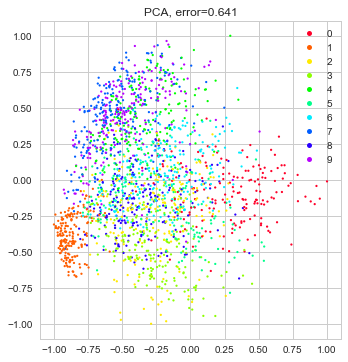

In [12]:
ax = plot_embed(X_pca, labels)
error = NN_generalization_error(X_pca, labels)
ax.set_title('PCA, error=%.3f' % error)

#### Perform Spectral Embedding using different _k_ to construct kNN graph

Spectral Embedding: 
0. Compute the pairwise distance matrix
0. Construct a kNN graph based on the pairwise distance matrix
0. Perform PCA on the Laplacian matrix of the kNN graph

In [13]:
#for n_neighbors in [1, 5, 10, 20, 30, 40, 50, 100]:
 #   se = manifold.SpectralEmbedding(affinity='nearest_neighbors', n_neighbors=n_neighbors)
#  X_se = se.fit_transform(X_pca[:, :50])
   # ax = plot_embed(X_se, labels)
  #   error = NN_generalization_error(X_se, labels)
   # ax.set_title('n_neighbors = %d, error=%.3f' % (n_neighbors, error))

#### Perform t-SNE

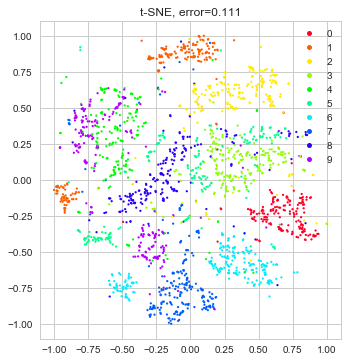

In [14]:
tsne = manifold.TSNE(metric='euclidean')

X_tsne = tsne.fit_transform(X_pca[:, :50])
# X_tsne = tsne.fit_transform(X)
ax = plot_embed(X_tsne, labels)
error = NN_generalization_error(X_tsne, labels)
ax.set_title('t-SNE, error=%.3f' % error)

### DR by the firework network layout

**How to convert the pairwise distance/similarity matrix to a graph?** 

- kNN graph
- Thresholding

#### Uses kNN graph for the layout 

In [15]:
from collections import Counter, OrderedDict
from sklearn.metrics.pairwise import pairwise_distances

# modules to interact with CyREST, the API of Cytoscape
#from py2cytoscape.data.cyrest_client import CyRestClient
#import py2cytoscape.cytoscapejs as renderer

In [16]:
def compute_adjcency_mat(X, metric='euclidean'):
    pdist = pairwise_distances(X, metric=metric)
    adj_mat = 1 - pdist / pdist.max()
    # remove 1's on the diagnal
    adj_mat -= np.eye(X.shape[0])
    return adj_mat

def plot_degree_distribution(G):
    """G: a nx.Graph object
    """
    fig, ax = plt.subplots(figsize=(5,5))
    
    degrees = G.degree().values()
    degrees = dict(Counter(degrees))
    x = degrees.keys()
    y = degrees.values()

    ax.scatter(x, y, s=10, alpha=.6)
    ax.set_xlabel('Degree', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)    
    ax.set_xscale('log')
    ax.set_yscale('log')
    fig.tight_layout()
    return ax
    
def create_knn_graph(X, k=30, metric='euclidean'):
    '''Create a graph from a data matrix (sample x features).
    '''
    adj_mat = neighbors.kneighbors_graph(X, k, mode='connectivity', metric=metric)
    G = nx.from_scipy_sparse_matrix(adj_mat)
    return G

2000 1562


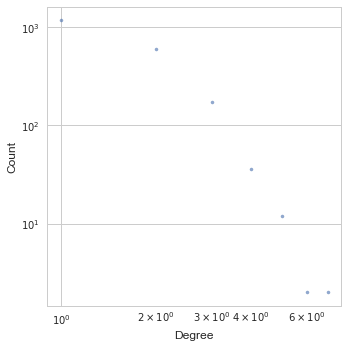

In [17]:
# G = create_knn_graph(X_pca[:, :50], k=30)
G = create_knn_graph(X_pca[:, :50], k=1)
print G.number_of_nodes(), G.number_of_edges()
plot_degree_distribution(G)

In [18]:
# G[0][0]
edge_betweeness = nx.edge_betweenness_centrality(G, weight='weight')

In [19]:
print G.number_of_nodes(), G.number_of_edges()
print len(edge_betweeness)

2000 1562
1562


In [20]:
print max(edge_betweeness.values()), min(edge_betweeness.values())

3.15157578789e-05 5.00250125063e-07


3.00150075038e-06
4.0020010005e-06
5.00250125063e-06
6.50325162581e-06
1.00050025013e-05
1.30065032516e-05


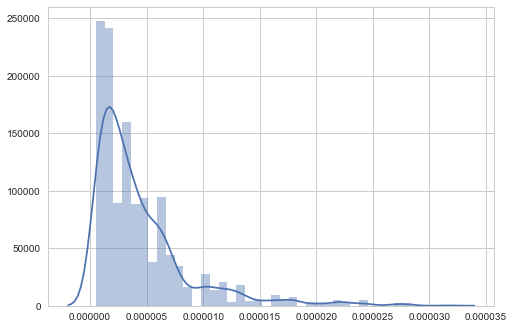

In [21]:
all_edge_betweeness_values = edge_betweeness.values()

for percentile in [50, 60, 70, 80, 90, 95]:
    print np.percentile(all_edge_betweeness_values, percentile)

sns.distplot(all_edge_betweeness_values)

In [22]:
#edges_to_remove = [e for e, val in edge_betweeness.items() if val < np.percentile(all_edge_betweeness_values, 50)]
#G.remove_edges_from(edges_to_remove)
print G.number_of_nodes(), G.number_of_edges()

2000 1562


In [73]:
def rescale_layout(pos,scale=1.):
    maxlim=0
    for i in range(pos.shape[1]):
        pos[:,i]-= pos[:,i].min()
        maxlim=max(maxlim,pos[:,i].max())
    if maxlim>0:
        for i in range(pos.shape[1]):
            pos[:,i]*=scale/maxlim
    return pos

def network_layout(G,iter,repulstype,repulsfactor,centralityfraction):
    adjmat=nx.adjacency_matrix(G)
    adjmat=adjmat.todense()
    a,b=adjmat.shape
    adjmat=np.asarray((adjmat),dtype='float64')
    iterations=iter
    pos_array=np.random.RandomState(42)
    pos=pos_array.rand(a,2)
    pos=pos.astype(adjmat.dtype)
    k=np.sqrt(1.0/a)
    #why is this multiplied by 0.1?
    t = max(max(pos.T[0]) - min(pos.T[0]), max(pos.T[1]) - min(pos.T[1]))*0.1
    #dt=t/float(iterations+1)
    dt=0.9
    energy=[]
    progress=0
    delta = np.zeros((pos.shape[0],pos.shape[0],pos.shape[1]),dtype=adjmat.dtype)
    degree=nx.degree_centrality(G)
    betweenness=nx.betweenness_centrality(G)
    betweenness=np.array(betweenness.values(),dtype='float64')*(1-centralityfraction)
    degree=np.array(degree.values(),dtype='float64')*centralityfraction
    degreemat=[[i*j/centralityfraction for i in degree]for j in degree]
    betweenmat=[[i*j/(1-centralityfraction) for i in betweenness] for j in betweenness]
    centralitymat=[[x+y for x,y in zip(degreemat[i],betweenmat[i])]for i in range(len(betweenmat))]
    for iteration in range(iterations):
        for i in range(pos.shape[1]):
            delta[:,:,i]=pos[:,i,None]-pos[:,i]
        delta=np.array(delta,dtype=np.float64)
        #if magnitude of delta<R(k), global force=0       
        distance=np.sqrt((delta**2).sum(axis=-1))
        distance=np.where(distance<0.01,0.01,distance)

        
        if repulstype =='edgespring1':
            edgeforce=degree/distance**2
            # old version used in jupyter
            #edgeforce=edgeforce/edgefactor
            edgeforce=degree + betweenness
            edgeforce=edgeforce/distance**2
            springrepuls=k*k*k/distance**2
            edgerepuls=edgeforce/(repulsfactor)
            force1=springrepuls+edgerepuls
            force1=force1/repulsfactor    
        if repulstype == 'edgespring2':  
            force_edge=centralitymat
            force_edge=force_edge/(distance**2)
            # old version used in jupyter
            #force1=force_edge/edgefactor+(k*k/distance**2)/repulsfactor
            force1=force_edge/repulsfactor/10+(k*k*k/distance**2)/repulsfactor        
        if repulstype == 'trial':
            force_edge=centralitymat
            force_edge=force_edge/(distance**2)
            # old version used by jupyter
            #force1=force_edge/edgefactor
            force1=force_edge/repulsfactor
        if repulstype == 'linlog':
            force_edge=centralitymat
            force_edge=force_edge*np.log(distance)
            force1=-1*force_edge
        if repulstype == 'noedge':
            force1=k*k/distance**2
            force1*=1/repulsfactor
        if repulstype == 'spring':
            force1=k*k/distance
            force1*=1/repulsfactor

        #attraction function
        force2=adjmat*distance/k
        forces=force1-force2
        displacement=np.transpose(np.transpose(delta)*(forces)).sum(axis=1)
        length=np.sqrt((displacement**2).sum(axis=1))
        energy.append(length.sum(axis=0))
        #in order to avoid dividing by zero or a v small number
        length=np.where(length<0.01,0.01,length)
        #does displacement 
        delta_pos=np.transpose(np.transpose(displacement)*t/length)
        pos+=delta_pos
        #t-=dt
        if (iteration>0 and energy[iteration]<energy[iteration-1]):
            progress+=1
            if progress>=5:
                progress=0
                t=t/dt
        else: 
            progress=0
            t*=dt        
        #for no fixed nodes only
        pos=rescale_layout(pos)
        #if delta_pos<tolerance
        #break loop, system has converged        
    
    return pos, G
    


    

In [74]:
#X_knn_fw, G_cy = network_layout(G,50,'trial',10)


In [75]:
# Display the current layout from Cytoscape
#display.Image(G_cy.get_png())
#print(NN_generalization_error(X_knn_fw,labels))

In [76]:
#error = NN_generalization_error(X_knn_fw, labels)
#ax = plot_embed(X_knn_fw, labels)
#ax.set_title('kNN Firework, error=%.3f' % error)
#check repuls force
#error = [NN_generalization_error(network_layout(G,50,'trial',i)[0],labels) for i in [10]]

#print(error)

#check betweeness cutoff

In [159]:
from py2cytoscape.data.cyrest_client import CyRestClient
import py2cytoscape.cytoscapejs as renderer

# Params for CyREST
IP = '127.0.0.1'
PORT = 1234
BASE_URL = 'http://%s:%s/v1' % (IP, PORT)
HEADERS = {'Content-Type': 'application/json'}

def cy_network_layout(G):
    '''POST the network to CyREST, then run layout algorithm, 
    finally return the coordinates and the cy_network.
    '''
    # Create Py2cytoscape client
    cy = CyRestClient(ip=IP, port=PORT)
    # Reset session
    cy.session.delete()
    # POST the graph to CyREST
    G_cy = cy.network.create_from_networkx(G)

    # Change the layout params
    layout_parameters = [
        {"name": "numIterations", "value": 1000}, 
    ]
   # resp = requests.put(BASE_URL+ '/apply/layouts/force-directed/parameters', 
    #              data=json.dumps(layout_parameters),
     #           headers=HEADERS)
    cy.layout.apply(name='circular', network=G_cy)
    # Get current view
    view = G_cy.get_first_view()
    nodes = view['elements']['nodes']
    # Get a coord matrix ordered by id_original
    ids_original = np.array([n['data']['id_original'] for n in nodes]).astype(np.int32)
    xs = [n['position']['x'] for n in nodes]
    ys = [n['position']['y'] for n in nodes]
    coords = np.array([xs, ys]).T
    return coords[ids_original], G_cy

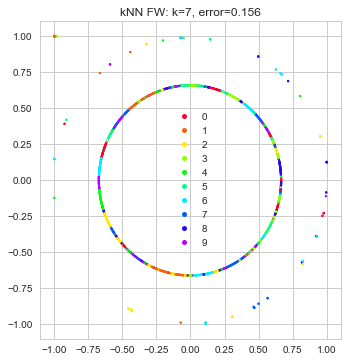

In [160]:
G = create_knn_graph(X_pca[:, :50], k=2)
X_knn_fw, G_cy = cy_network_layout(G)
error = NN_generalization_error(X_knn_fw, labels)
ax = plot_embed(X_knn_fw, labels)
ax.set_title('kNN FW: k=%d, error=%.3f' % (k, error))




In [124]:
def nx_network_layout(G):
    pos=nx.spring_layout(G)

    return pos2, G

In [125]:
G = create_knn_graph(X_pca[:, :50], k=2)
X_knn_fw, G_cy = nx_network_layout(G)
error = NN_generalization_error(X_knn_fw, labels)
ax = plot_embed(X_knn_fw, labels)
ax.set_title('kNN FW: k=%d, error=%.3f' % (k, error))

TypeError: list indices must be integers, not tuple

In [129]:
from IPython.display import display
G = create_knn_graph(X_pca[:, :50], k=2)
pos=nx.spring_layout(G)


In [164]:
pos2=pos.values()
display(pos2[1])
pos4=[[]]*len(pos2)
for i in range(len(pos2)):
    pos4[i][0]=pos2[i][0]
    pos4[i][1]=pos2[i][1]

display(pos4)

array([ 0.24152213,  0.38721678], dtype=float32)

IndexError: list assignment index out of range

In [131]:
#for k in [1, 5, 10, 20, 30, 40, 50, 100]:
#    G = create_knn_graph(X_pca[:, :50], k=k)
#    X_knn_fw, G_cy = network_layout(G,50)
#    error = NN_generalization_error(X_knn_fw, labels)
#   ax = plot_embed(X_knn_fw, labels)
#    ax.set_title('kNN FW: k=%d, error=%.3f' % (k, error))


In [78]:
error={}
for k in [4,6,7]:
    G = create_knn_graph(X_pca[:, :50], k=k)
    # X_knn_fw, G_cy = network_layout(G,50,'trial',10)
    error[k] = [[[NN_generalization_error(network_layout(G,50,j,i,p)[0],labels) for i in [100]]for p in [.99,.5,.01]]for j in ['edgespring1','edgespring2','trial','linlog']]
print error
    #error = NN_generalization_error(X_knn_fw, labels)
    #ax = plot_embed(X_knn_fw, labels)
   # ax.set_title('kNN FW: k=%d, error=%.3f' % (k, error))


{4: [[[0.42400901322160844], [0.4669282228371221], [0.41897842163420063]], [[0.37996502967503132], [0.36895242410009799], [0.39392463048379733]], [[0.38442401060872455], [0.36947261812231824], [0.36297443467179247]], [[0.37635613003735879], [0.44239086086370893], [0.43650352534661185]]], 6: [[[0.49145802174267084], [0.47042256530415061], [0.4733645653260663]], [[0.53950258555226949], [0.51890875990600416], [0.51202661570881702]], [[0.4943937318242716], [0.53194552738376699], [0.47892886809161728]], [[0.47896281706802057], [0.48449826412308172], [0.45651731052938704]]], 7: [[[0.49451694268520341], [0.5310180683853889], [0.5029373823525225]], [[0.53798588066532627], [0.52101855651417983], [0.53241034350638827]], [[0.52794964407721745], [0.54854089386955329], [0.5405266459374094]], [[0.52792909020879519], [0.48798953429452696], [0.53803281244430534]]]}


#### Perform thresholding to form graphs for the Firework layout

In [ ]:
# thresholding-Firework
def create_graph_by_threshold(adj_mat, percentile):
    triu_idx = np.tril_indices(adj_mat.shape[0], 1)
    thresold = np.percentile(adj_mat[triu_idx], percentile)
    adj_mat_ = adj_mat.copy()
    adj_mat_[adj_mat<thresold] = 0
    G = nx.from_numpy_matrix(adj_mat_)
    return G

def create_graph_by_threshold_knn(adj_mat, percentile, k=1, X=None):
    '''combine the graph from `create_graph_by_threshold` with a kNN graph.
    '''
    G_thres = create_graph_by_threshold(adj_mat, percentile)
    G_knn = create_knn_graph(X, k=k)
    return nx.compose(G_thres, G_knn)

In [ ]:
adj_mat = compute_adjcency_mat(X_pca[:, :50], metric='euclidean')
print adj_mat.shape
adj_mat[:5, :5]

In [ ]:
# Histogram for values in adj_mat
triu_idx = np.triu_indices(adj_mat.shape[0], 1)
sns.distplot(adj_mat[triu_idx])

In [ ]:
percentile = 99.5 
# percentile = 90
G = create_graph_by_threshold(adj_mat, percentile)
print G.number_of_nodes(), G.number_of_edges()
plot_degree_distribution(G)

In [ ]:
k = 4
G_thres_knn = create_graph_by_threshold_knn(adj_mat, percentile, k=k, X=X_pca[:, :50])
print G_thres_knn.number_of_edges(), G_thres_knn.number_of_nodes()
plot_degree_distribution(G_thres_knn)

In [ ]:
X_thre_fw, G_cy = network_layout(G,50,'trial',10)
X_threknn_fw, G_cy = network_layout(G_thres_knn,50,'trial',10)

In [ ]:
ax = plot_embed(X_thre_fw, labels)
error = NN_generalization_error(X_thre_fw, labels)
ax.set_title('threshold=%.1f%%, error=%.3f' %(percentile, error))

ax = plot_embed(X_threknn_fw, labels)
error = NN_generalization_error(X_threknn_fw, labels)
ax.set_title('threshold=%.1f%%, k=%d, error=%.3f' %(percentile, k, error))

In [ ]:
display.Image(G_cy.get_png())

#### Problem: there are some small connected components and even isolated nodes, how to deal with them?

Current ~~solution~~: exclude

In [ ]:
G_new = nx.Graph()
G_new_tknn = nx.Graph()
for cc in nx.connected_component_subgraphs(G):
    if cc.number_of_nodes() > 10:
        G_new = nx.compose(G_new, cc)
print G_new.number_of_nodes(), G_new.number_of_edges()

for cc in nx.connected_component_subgraphs(G_thres_knn):
    if cc.number_of_nodes() > 10:
        G_new_tknn = nx.compose(G_new_tknn, cc)
print G_new_tknn.number_of_nodes(), G_new_tknn.number_of_edges()

To make a fair comparison between thresholding-Firework and t-SNE, re-compute the error by ignoring nodes in the small connected components.

In [ ]:
# Re-compute the error by ignoring the small CCs
node_idx_in_graph = G_new.nodes()
# node_idx_in_graph = G_new_Gknn.nodes()
sample_mask = np.in1d(np.arange(N), node_idx_in_graph)

ax = plot_embed(X_thre_fw[sample_mask], labels[sample_mask])
error = NN_generalization_error(X_thre_fw[sample_mask], labels[sample_mask])
ax.set_title('threshold=%.1f%%, error=%.3f' %(percentile, error))

ax = plot_embed(X_threknn_fw, labels)
error = NN_generalization_error(X_threknn_fw[sample_mask], labels[sample_mask])
ax.set_title('threshold=%.1f%%, k=%d, error=%.3f' %(percentile, k, error))

In [ ]:
# Re-compute the error by ignoring the small CCs
node_idx_in_graph = G_new.nodes()
sample_mask = np.in1d(np.arange(N), node_idx_in_graph)

ax = plot_embed(X_thre_fw[sample_mask], labels[sample_mask])
error = NN_generalization_error(X_thre_fw[sample_mask], labels[sample_mask])
ax.set_title('threshold=%.1f%%, error=%.3f' %(percentile, error))

ax = plot_embed(X_tsne, labels)
error = NN_generalization_error(X_tsne[sample_mask], labels[sample_mask])
ax.set_title('t-SNE, error=%.3f' %error)

<a id="refs"></a>

## References

+ [Making sense of principal component analysis, eigenvectors & eigenvalues](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)
+ [MNIST For ML Beginners](https://www.tensorflow.org/get_started/mnist/beginners)
+ [Visualizing MNIST: An Exploration of Dimensionality Reduction](http://colah.github.io/posts/2014-10-Visualizing-MNIST/)
+ [Tensorflow Embedding Projector](http://projector.tensorflow.org/)
+ [van der Maaten's t-SNE page](http://lvdmaaten.github.io/tsne/)
+ [van der Maaten et al.: Dimensionality Reduction: A Comparative Review](https://www.tilburguniversity.edu/upload/59afb3b8-21a5-4c78-8eb3-6510597382db_TR2009005.pdf)
+ [van der Maaten: Learning a Parametric Embedding by Preserving Local Structure](http://lvdmaaten.github.io/publications/papers/AISTATS_2009.pdf)
+ [Kokiopoulou and Saad: Enhanced graph-based dimensionality reduction with repulsion Laplaceans](http://www.sciencedirect.com/science/article/pii/S0031320309001460)